# Damped Harmonic Oscillator Baseline comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


\begin{align}
\ddot{x}(t) + 2\beta\omega_0\dot{x}(t) + \omega_0^2x(t) = 0
\end{align}

Ansatz, $x = \exp(\gamma t)$; $\gamma = -\omega_0\left[\beta \pm i\sqrt{1 - \beta^2}\right]$

In [3]:
def damped_sho(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = torch.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = torch.exp(-envel * tau) * torch.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0
    return data

def damped_sho_bilby(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = np.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = np.exp(-envel * tau) * np.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0

    return data

## Plot

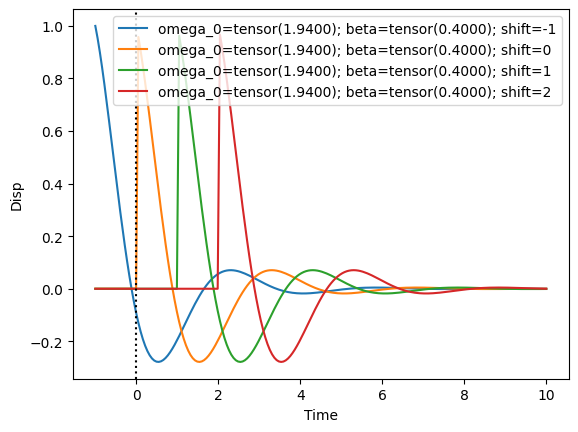

In [4]:
omega_0 = torch.tensor(1.94)
beta = torch.tensor(0.4)

t_vals = torch.linspace(-1, 10, 200)
for shift in [-1, 0, 1, 2]:
    x_vals = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{omega_0=}; {beta=}; {shift=}")
plt.xlabel("Time")
plt.ylabel("Disp")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()

In [5]:
injection_parameters = dict(omega_0=omega_0, beta=beta, shift=2)
print(injection_parameters)

{'omega_0': tensor(1.9400), 'beta': tensor(0.4000), 'shift': 2}


In [6]:
num_points = 200
t_vals = np.linspace(-1, 10, num_points)

In [7]:
sigma = 0.4

In [8]:
data = damped_sho(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0, 0.5, 'y')

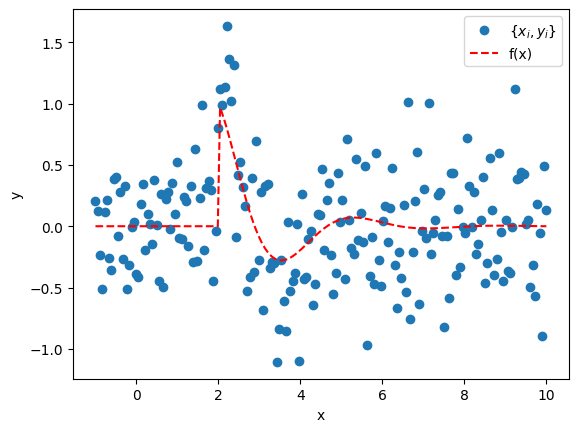

In [9]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, damped_sho(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [10]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [11]:
priors = dict()

priors['omega_0'] = Uniform(0.1, 2, name='omega_0', latex_label='$\omega_0$') #np array
priors['beta'] = Uniform(0, 0.5, name='beta', latex_label='$\\beta$') #np array
priors['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

In [12]:
from IPython.display import clear_output
from time import sleep

In [13]:
import torch

def get_data(omega_0=None, beta=None, shift=None, num_points=1):
    """Sample omega, beta, shift and return a batch of data with noise"""
    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
    beta = priors['beta'].sample() if beta is None else beta
    beta = torch.tensor(beta).to(dtype=torch.float32)
    shift = priors['shift'].sample() if shift is None else shift
    shift = torch.tensor(shift).to(dtype=torch.float32)

    t_vals = torch.linspace(-1, 10, num_points).to(dtype=torch.float32) #

    y = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    y += sigma * torch.randn(size=y.size()).to(dtype=torch.float32)

    return t_vals, y, omega_0, beta, shift

# Add augmentation

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [15]:
%%time

num_simulations = 100000
num_repeats = 10

theta_unshifted_vals = []
theta_shifted_vals = []
data_unshifted_vals = []
data_shifted_vals = []

for ii in range(num_simulations):
    # generated data with a fixed shift
    t_vals, y_unshifted, omega, beta, shift = get_data(num_points=num_points, shift=1)
    # create repeats
    theta_unshifted = torch.tensor([omega, beta, shift]).repeat(num_repeats, 1).to(device=device)
    theta_unshifted_vals.append(theta_unshifted)
    data_unshifted_vals.append(y_unshifted.repeat(num_repeats, 1).to(device=device))
    # generate shifted data
    theta_shifted = []
    data_shifted = []
    for _ in range(num_repeats):
        t_val, y_shifted, _omega, _beta, shift = get_data(
            omega_0=omega, beta=beta,  # omega and beta same as above
            shift=None,
            num_points=num_points
        )
        theta_shifted.append(torch.tensor([omega, beta, shift]))
        data_shifted.append(y_shifted)
    theta_shifted_vals.append(torch.stack(theta_shifted).to(device=device))
    data_shifted_vals.append(torch.stack(data_shifted).to(device=device))

/tmp/ipykernel_25876/3156004060.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
/tmp/ipykernel_25876/3156004060.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta).to(dtype=torch.float32)


CPU times: user 1min 9s, sys: 696 ms, total: 1min 9s
Wall time: 1min 11s


In [16]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (
            theta_shifted_vals[idx].to(dtype=torch.float32),
            theta_unshifted_vals[idx].to(dtype=torch.float32),
            data_shifted_vals[idx].to(dtype=torch.float32),
            data_unshifted_vals[idx].to(dtype=torch.float32)
        )

In [17]:
dataset = DataGenerator()

Text(0.5, 1.0, 'Augmented sample; $\\omega_0$ = 0.8; $\\beta$ = 0.2')

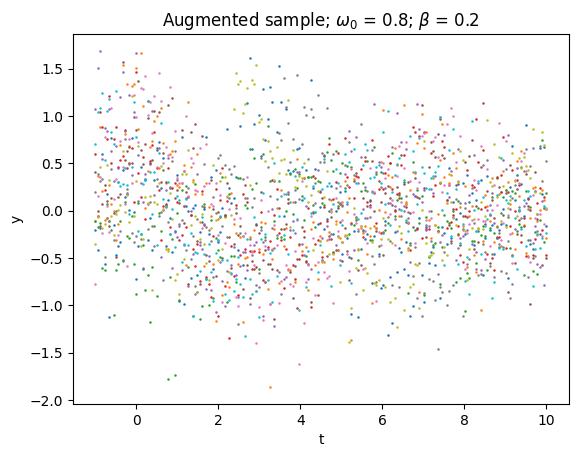

In [18]:
_, t, d, _ = dataset[6]

fig, ax = plt.subplots()

for (omega, beta, shift), points in zip(t, d):
    ax.plot(t_vals.clone().detach().cpu().numpy(), points.clone().detach().cpu().numpy(),
            'o', markersize=0.8)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_title(f"Augmented sample; $\\omega_0$ = {t[0][0]:.1f}; $\\beta$ = {t[0][1]:.1f}")

In [19]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [20]:
TRAIN_BATCH_SIZE = 1000
VAL_BATCH_SIZE = 1000

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [21]:
for theta, _, data_aug, data_orig in train_data_loader:
    break

In [22]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(80, 10, 10000)

In [23]:
theta.shape, data_aug.shape, data_orig.shape

(torch.Size([1000, 10, 3]),
 torch.Size([1000, 10, 200]),
 torch.Size([1000, 10, 200]))

In [24]:
len(val_data_loader)

10

#  No Embedding Net used

In [25]:
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

import nflows.utils as torchutils

In [26]:
num_transforms = 5
num_blocks = 4
hidden_features = 50

context_features = num_points

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01,
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [27]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  355020


# Train/Validate

In [28]:
num_augmentations = 10

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 5 == 0:
            last_loss = running_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [29]:
optimizer = optim.SGD(flow.parameters(), lr=1e-3, momentum=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=0.01)

In [30]:
# writer = SummaryWriter("damped-harmonic-oscillator-baseline.neurips", comment="With LR=1e-3", flush_secs=5)
# epoch_number = 0

In [31]:
PATH2 = './damped-harmonic-oscillator-baseline.neurips.pth'
flow.load_state_dict(torch.load(PATH2, map_location=device))
flow.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
          (context_layer): Linear(in_features=200, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-3): 4 x MaskedResidualBlock(
              (context_layer): Linear(in_features=200, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.01, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=50, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)


In [32]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 30

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     flow.train(True)
#     # flow._embedding_net.train(False)
#     # no gradient tracking for embedding layer
#     for name, param in flow._embedding_net.named_parameters():
#         param.requires_grad = False

#     avg_train_loss = train_one_epoch(epoch_number, writer)

#     # no gradient tracking, for validation
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)

#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step(avg_val_loss)

In [33]:
# PATH2 = './damped-harmonic-oscillator-baseline.neurips.pth'
# torch.save(flow.state_dict(), PATH2)

# Check on test data

In [34]:
import pandas as pd
import corner

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys({'omega_0', 'beta'})
    injections['omega_0'] = float(truth.numpy()[0])
    injections['beta'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'omega_0', 'beta'})
    samples_numpy = samples.numpy()
    posterior['omega_0'] = samples_numpy.T[0].flatten()
    posterior['beta'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)

    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [35]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "beta",],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

## Posteriors

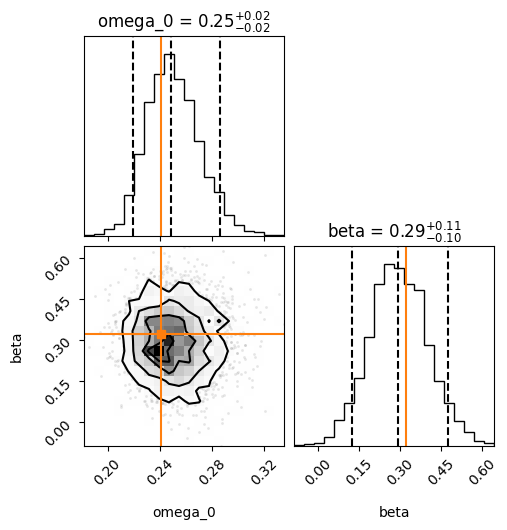

In [36]:
for idx, (_, theta_test, data_test, data_orig) in enumerate(test_data_loader):
    if idx % 1000 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 200)))
    live_plot_samples(samples.cpu().reshape(3000,2), theta_test[0][0].cpu()[...,0:2])
    plt.show()

# Comparison with bilby and analytic result

In [37]:
import bilby
bilby_result = bilby.result.Result.from_json('./bilby_sho.json', outdir=None)

In [38]:
bilby_result.injection_parameters.pop('shift')
injection_parameters = bilby_result.injection_parameters.copy()

In [39]:
injection_parameters

{'omega_0': 1.5, 'beta': 0.2}

In [40]:
flow_sim_result = bilby.result.Result.from_json(filename='./sim_flow_sho.json', outdir=None)

In [41]:
x_vals = damped_sho_bilby(t_vals, **injection_parameters)

In [42]:
try:
    x_vals = torch.from_numpy(x_vals).to(device, dtype=torch.float32)
except TypeError:
    x_vals = x_vals.to(device, dtype=torch.float32)

In [43]:
with torch.no_grad():
    flow_samples = flow.sample(3000, context=x_vals.reshape((1, 200)))

In [44]:
flow_result = cast_as_bilby_result(flow_samples.cpu().reshape(3000, 2),
                                   torch.tensor(list(injection_parameters.values())))

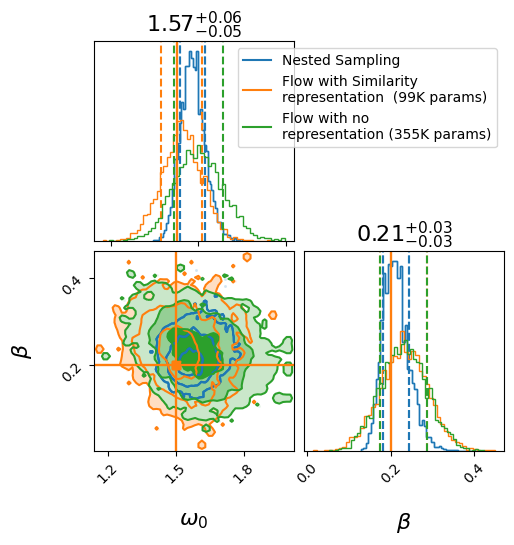

In [45]:
fig = bilby.result.plot_multiple(
    [bilby_result, flow_sim_result, flow_result],
    labels=['Nested Sampling',
            'Flow with Similarity \nrepresentation  (99K params)',
            'Flow with no \nrepresentation (355K params)'],    
    truth=injection_parameters,
    quantiles=(0.16, 0.84),
    titles=True, save=True,
    filename='sho-comparison-bilby-with-sim.pdf'
)